# Phase 3 Project
- author: Jonathan Holt
- Flatiron Data Science
- 7/19/21 Cohort

In [60]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_rows', 1000) #change the amount of rows displayed
plt.style.use('seaborn')

In [3]:
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Fixing column names

In [4]:
df.columns = df.columns.str.replace(' ','_')
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

# Inital Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   phone_number            3333 non-null   object 
 4   international_plan      3333 non-null   object 
 5   voice_mail_plan         3333 non-null   object 
 6   number_vmail_messages   3333 non-null   int64  
 7   total_day_minutes       3333 non-null   float64
 8   total_day_calls         3333 non-null   int64  
 9   total_day_charge        3333 non-null   float64
 10  total_eve_minutes       3333 non-null   float64
 11  total_eve_calls         3333 non-null   int64  
 12  total_eve_charge        3333 non-null   float64
 13  total_night_minutes     3333 non-null   float64
 14  total_night_calls       3333 non-null   

In [6]:
df.describe()

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [7]:
df.isna().sum()

state                     0
account_length            0
area_code                 0
phone_number              0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_day_charge          0
total_eve_minutes         0
total_eve_calls           0
total_eve_charge          0
total_night_minutes       0
total_night_calls         0
total_night_charge        0
total_intl_minutes        0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
dtype: int64

In [8]:
df.churn.value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [9]:
df['customer_service_calls'].value_counts()

1    1181
2     759
0     697
3     429
4     166
5      66
6      22
7       9
9       2
8       2
Name: customer_service_calls, dtype: int64

# Cleaning and Preprocessing

In [10]:
df.head()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [11]:
test_df = df.copy()
test_df.head(2)

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


## Changing Yes and No to 0 and 1

In [12]:
test_df["churn"] = test_df["churn"].astype(int)

In [13]:
test_df.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

## Train Test Split

In [16]:
X = test_df.drop(['churn'], axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=23)

## Slicing out Object-types

In [17]:
#code from Ridge and Lasso Regression Lab
cont_features = [col for col in X.columns if X[col].dtype in [np.float64, np.int64]]

In [19]:
cont_features

['account_length',
 'area_code',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'customer_service_calls']

In [20]:
#code from Ridge and Lasso Regression Lab
X_train_cont = X_train.loc[:, cont_features]
X_test_cont = X_test.loc[:, cont_features]

# Linear Regression

In [23]:
impute = SimpleImputer(strategy='median')

In [24]:
X_train_imputed = impute.fit_transform(X_train_cont)
X_test_imputed = impute.transform(X_test_cont)

In [25]:
linreg = LinearRegression()

In [26]:
linreg.fit(X_train_imputed, y_train)

LinearRegression()

In [27]:
print('Training r^2:', linreg.score(X_train_imputed, y_train))
print('Test r^2:', linreg.score(X_test_imputed, y_test))
print('Training MSE:', mean_squared_error(y_train, linreg.predict(X_train_imputed)))
print('Test MSE:', mean_squared_error(y_test, linreg.predict(X_test_imputed)))

Training r^2: 0.11476504184591119
Test r^2: 0.10828265694060302
Training MSE: 0.10839611732499047
Test MSE: 0.11436652223493536


## Normalizing

In [29]:
# Scale the train and test data
ss = StandardScaler()
X_train_imputed_scaled = ss.fit_transform(X_train_imputed)
X_test_imputed_scaled = ss.transform(X_test_imputed)

# Fit the model 
linreg_norm = LinearRegression()
linreg_norm.fit(X_train_imputed_scaled, y_train)

# Print R2 and MSE for training and test sets
print('Training r^2:', linreg_norm.score(X_train_imputed_scaled, y_train))
print('Test r^2:', linreg_norm.score(X_test_imputed_scaled, y_test))
print('Training MSE:', mean_squared_error(y_train, linreg_norm.predict(X_train_imputed_scaled)))
print('Test MSE:', mean_squared_error(y_test, linreg_norm.predict(X_test_imputed_scaled)))

Training r^2: 0.11476504184591119
Test r^2: 0.10828265694060546
Training MSE: 0.10839611732499047
Test MSE: 0.11436652223493506


This didn't do anything???

## Getting Dummies
- Exclude Target (y)
- Exclude Phone Number (as this is the unique identifier)

In [31]:
ohe = OneHotEncoder()

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   phone_number            3333 non-null   object 
 4   international_plan      3333 non-null   object 
 5   voice_mail_plan         3333 non-null   object 
 6   number_vmail_messages   3333 non-null   int64  
 7   total_day_minutes       3333 non-null   float64
 8   total_day_calls         3333 non-null   int64  
 9   total_day_charge        3333 non-null   float64
 10  total_eve_minutes       3333 non-null   float64
 11  total_eve_calls         3333 non-null   int64  
 12  total_eve_charge        3333 non-null   float64
 13  total_night_minutes     3333 non-null   float64
 14  total_night_calls       3333 non-null   

In [41]:
X = X.drop(columns= ['state', 'phone_number'], axis=1)

In [42]:
X.head()

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
0,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [43]:
features_cat = [col for col in X.columns if X[col].dtype in [np.object]]
X_train_cat = X_train.loc[:, features_cat]
X_test_cat = X_test.loc[:, features_cat]

# Fill missing values with the string 'missing'
X_train_cat.fillna(value='missing', inplace=True)
X_test_cat.fillna(value='missing', inplace=True)

In [44]:
X_train_cat

,international_plan,voice_mail_plan
978,no,no
2156,no,no
1989,no,yes
2469,no,no
433,no,no
...,...,...
2998,no,no
1993,no,no
1064,yes,yes
742,no,yes


In [45]:
X_train_ohe = ohe.fit_transform(X_train_cat)
X_test_ohe = ohe.transform(X_test_cat)

In [47]:
columns = ohe.get_feature_names(input_features=X_train_cat.columns)
cat_train_df = pd.DataFrame(X_train_ohe.todense(), columns=columns)
cat_test_df = pd.DataFrame(X_test_ohe.todense(), columns=columns)

In [50]:
cat_train_df.head()

,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes
0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0


In [51]:
X_train_all = pd.concat([pd.DataFrame(X_train_imputed_scaled), cat_train_df], axis=1)
X_test_all = pd.concat([pd.DataFrame(X_test_imputed_scaled), cat_test_df], axis=1)

In [52]:
linreg_all = LinearRegression()
linreg_all.fit(X_train_all, y_train)

print('Training r^2:', linreg_all.score(X_train_all, y_train))
print('Test r^2:', linreg_all.score(X_test_all, y_test))
print('Training MSE:', mean_squared_error(y_train, linreg_all.predict(X_train_all)))
print('Test MSE:', mean_squared_error(y_test, linreg_all.predict(X_test_all)))

Training r^2: 0.1748781044726786
Test r^2: 0.1924263737986336
Training MSE: 0.10103533414620262
Test MSE: 0.1035747345234194


# Decision Tree

In [56]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=23)

dt.fit(X_train_all, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=23)

In [61]:
# Make predictions using test set 
y_pred = dt.predict(X_test_all)

# Check the AUC of predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8461797148237826

## Finding Optimal Tree Parameters

### Max Depth

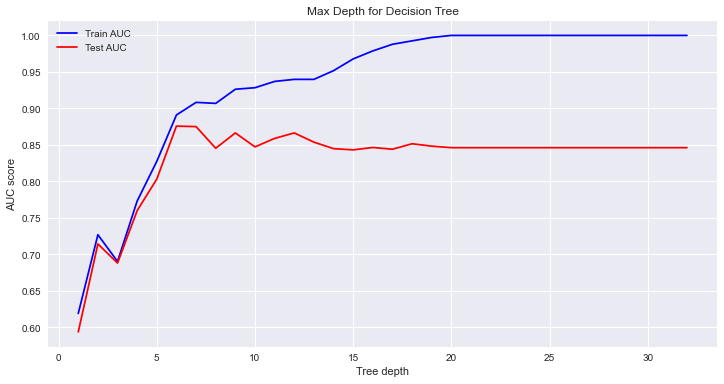

In [63]:
# Code is from Tuning Decision Tree Lab
# Identify the optimal tree depth for given data 
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=23)
   dt.fit(X_train_all, y_train)
   train_pred = dt.predict(X_train_all)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test_all)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.title('Max Depth for Decision Tree')
plt.legend()
plt.show()

Analysis:
- AUC for Test data decreases at a depth of 6-7. I should tune the tree depth to 6.

### Minimum Sample Split

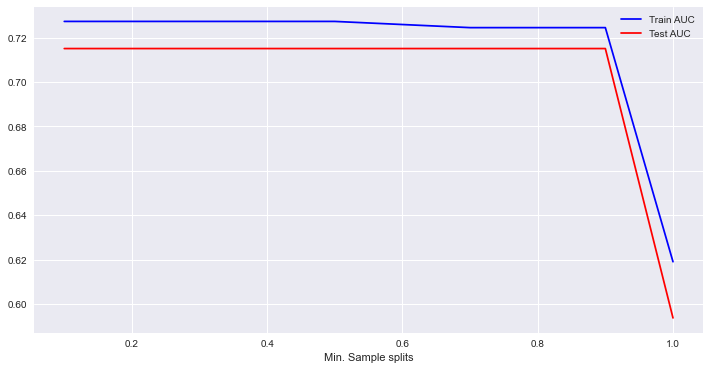

In [65]:
# Identify the optimal min-samples-split for given data
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=23)
   dt.fit(X_train_all, y_train)
   train_pred = dt.predict(X_train_all)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test_all)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

Analysis:
- Both Training and Test AUC are stable begining at <0.2. No need to do more samples than that.
- Will tune this parameter to 0.2

### Min Sample Leafs

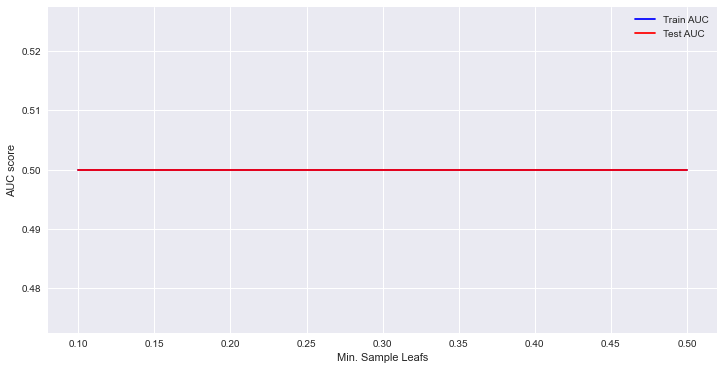

In [67]:
# Calculate the optimal value for minimum sample leafs
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=23)
   dt.fit(X_train_all, y_train)
   train_pred = dt.predict(X_train_all)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test_all)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

I must have done something wrong here!

### Maximum Features

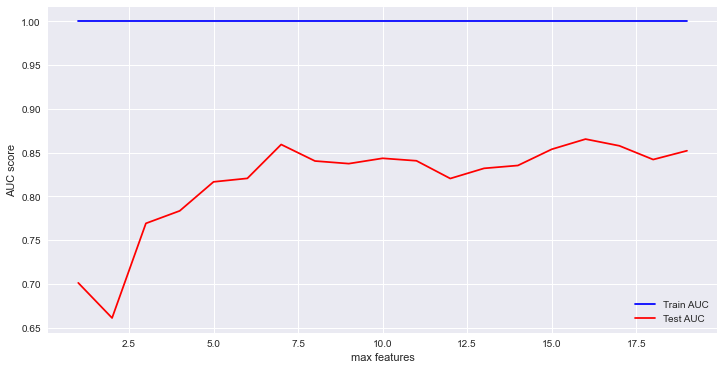

In [68]:
# Find the best value for optimal maximum feature size
max_features = list(range(1, X_train_all.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   dt = DecisionTreeClassifier(criterion='entropy', max_features=max_feature, random_state=23)
   dt.fit(X_train_all, y_train)
   train_pred = dt.predict(X_train_all)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test_all)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train AUC')
plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()
plt.show()

Analysis:
- Test AUC maxes out right before 7.5 features. So I should tune the max features to 7.
    

## Re-training Decision Tree with Tuned Parameters

In [75]:
dt = DecisionTreeClassifier(criterion='entropy', 
                           max_depth=6,
                           min_samples_split=0.2,
                            max_features=7,
                            random_state=23)
dt.fit(X_train_all, y_train)
y_pred = dt.predict(X_test_all)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6246637072908259

Analysis: I must have improperly tuned the Decision Tree as my ROC AUC is now worse than the vanilla tree was.

# Archive

## Logistic Regression

In [54]:
baseline_model = LinearRegression()

In [55]:
baseline_model.fit(X_train, y_train)

ValueError: could not convert string to float: 'VT'

In [ ]:
# Generate predictions using baseline_model and X_train
y_pred_baseline = baseline_model.predict(X_train)

# Evaluate using mean_squared_error with squared=False
baseline_rmse = mean_squared_error(y_train, y_pred_baseline, squared=False)
baseline_rmse

In [ ]:
# Get the cross validated scores for our baseline model
baseline_cv = cross_val_score(baseline_model, X_train, y_train, scoring="neg_root_mean_squared_error")

# Display the average of the cross-validated scores
baseline_cv_rmse = -(baseline_cv.mean())
baseline_cv_rmse